# Exploratory Data Analysis Project

### First let's import all the modules we need:

In [45]:
from db_utils import DataFrameInfo
from db_utils import DataFrameTransform
from db_utils import DataTransform
from db_utils import Plotter
from db_utils import RDSDatabaseConnector
import pandas as pd

### Now we'll initialise all the classes

In [46]:
my_frame_info = DataFrameInfo()
my_dataframe_transformer = DataFrameTransform()
my_transformer = DataTransform()
my_plotter = Plotter()
my_extractor = RDSDatabaseConnector(my_transformer.read_db_creds("db_creds.yaml"))


### We'll extract the database from `db_creds.yaml`, and give it the name `raw_df`.

In [47]:
my_extractor.rds_table_to_csv('failure_data', 'UDI') #Takes the table stored in the dataframe from `db_creds.yaml` and puts it in a csv called `csv_of_dataframe.csv`
raw_df = my_transformer.read_csv_as_dataframe('csv_of_dataframe.csv') #Reads the data in csv_of_dataframe.csv and transforms it to a pandas dataframe
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      9162 non-null   float64
 4   Process temperature [K]  9119 non-null   float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          9516 non-null   float64
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(4), int64(8)

We'll make modifications to the dataframe named `df`

In [48]:
df = raw_df

## Data Transformation:

- The columns relating to failure could be cast as booleans rather than integers
- The Type column could be cast as integers since the quality values of 'Low', 'Medium' and 'High' may have been intended to be ordinals.

In [49]:
def transform_data_boolean(dataframe, list_of_columns):
    for column_name in list_of_columns:
        dataframe = my_transformer.boolean_convert(dataframe, column_name)
    

transform_data_boolean(df, ['Machine failure', 'TWF','HDF','PWF','OSF','RNF']) # Makes the failure columns into booleans

df['Type'] = my_transformer.string_convert(df, 'Type', ['L', 'M', 'H']) #Makes the type column into ordinals where 'L' is 0, and so on...

df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,3416,L50595,0,301.4,310.4,1579,36.9,133.0,False,False,False,False,False,False
1,7130,L54309,0,300.6,310.0,1635,31.0,107.0,False,False,False,False,False,False
2,2320,M17179,1,299.2,308.8,1700,33.5,185.0,False,False,False,False,False,False
3,9601,M24460,1,298.9,310.0,1561,45.3,58.0,False,False,False,False,False,False
4,614,L47793,0,298.1,309.9,1634,30.0,53.0,False,False,False,False,False,False


## Null Value imputation

First let's examine the null values in our table:

In [50]:
def show_null_information(list_of_series): 
    for series in list_of_series:
        my_frame_info.null_value_information(series)

show_null_information([df[column] for column in df.columns[2:]])


Null value information for Type: 
Percentage of non-null values: 100.0 %
NormaltestResult(statistic=1200.2628547171475, pvalue=2.3239815797758362e-261)

Null value information for Air temperature [K]: 
Percentage of non-null values: 91.62 %
NormaltestResult(statistic=928.1812219102641, pvalue=2.805488927993442e-202)

Null value information for Process temperature [K]: 
Percentage of non-null values: 91.19 %
NormaltestResult(statistic=181.21832473316812, pvalue=4.455954774292699e-40)

Null value information for Rotational speed [rpm]: 
Percentage of non-null values: 100.0 %
NormaltestResult(statistic=4395.347068975414, pvalue=0.0)

Null value information for Torque [Nm]: 
Percentage of non-null values: 100.0 %
NormaltestResult(statistic=0.21260705444450384, pvalue=0.8991516896381224)

Null value information for Tool wear [min]: 
Percentage of non-null values: 95.16 %
NormaltestResult(statistic=6306.895815369672, pvalue=0.0)

Null value information for Machine failure: 
Percentage of no

The only columns with missing values are `Air temperature [K]`, `Air temperature [K]` and `Tool wear [min]`. Let's add new columns representing the missing values and look at the correlation matrix.

In [51]:
df['Missing Air Temp'] = df['Air temperature [K]'].isnull()

df['Missing Process Temp'] = df['Process temperature [K]'].isnull()

df['Missing Tool Wear'] = df['Tool wear [min]'].isnull()

df.corr()

/tmp/ipykernel_33235/2223981952.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,UDI,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Missing Air Temp,Missing Process Temp,Missing Tool Wear
UDI,1.000000,0.002058,0.112386,0.326121,-0.006615,0.003207,-0.013122,-0.022892,0.009154,-0.022215,-0.023557,-0.000990,-0.005954,-0.013900,-0.011770,0.007695
Type,0.002058,1.000000,-0.019212,-0.015058,-0.003979,-0.003097,-0.007115,-0.036715,0.010977,-0.014719,-0.010026,-0.054486,0.001691,0.001478,0.022724,0.019335
Air temperature [K],0.112386,-0.019212,1.000000,0.874785,0.024038,-0.015738,0.015173,0.081176,0.009531,0.137731,0.004529,-0.000433,0.022905,NaN,-0.004229,-0.006793
Process temperature [K],0.326121,-0.015058,0.874785,1.000000,0.014504,-0.010805,0.007687,0.037783,0.010234,0.057215,-0.004306,0.004988,0.021019,-0.007829,NaN,-0.007217
Rotational speed [rpm],-0.006615,-0.003979,0.024038,0.014504,1.000000,-0.875027,-0.002751,-0.044188,0.010389,-0.121241,0.123018,-0.104575,-0.013088,-0.023121,-0.000017,0.007775
Torque [Nm],0.003207,-0.003097,-0.015738,-0.010805,-0.875027,1.000000,0.000995,0.191321,-0.014662,0.142610,0.083781,0.183465,0.016136,0.018572,0.007950,-0.015653
Tool wear [min],-0.013122,-0.007115,0.015173,0.007687,-0.002751,0.000995,1.000000,0.104016,0.115461,-0.002151,-0.009766,0.156474,0.011430,-0.014147,-0.010687,NaN
Machine failure,-0.022892,-0.036715,0.081176,0.037783,-0.044188,0.191321,0.104016,1.000000,0.362904,0.575800,0.522812,0.531083,0.004516,-0.008791,-0.001688,-0.013923
TWF,0.009154,0.010977,0.009531,0.010234,0.010389,-0.014662,0.115461,0.362904,1.000000,-0.007332,0.008577,0.038243,0.030970,-0.004559,-0.015916,-0.001559
HDF,-0.022215,-0.014719,0.137731,0.057215,-0.121241,0.142610,-0.002151,0.575800,-0.007332,1.000000,0.018443,0.046396,-0.004706,0.001229,-0.000435,-0.002474


We see that all the missing value columns have no correlation to anything, so it's safe to impute the mean for all those columns.

In [52]:
def impute_median_of_all_columns(dataframe, list_of_columns):
    for column in list_of_columns:
        dataframe[column] = my_dataframe_transformer.impute_median(dataframe[column])

impute_median_of_all_columns(df, ['Air temperature [K]','Process temperature [K]', 'Tool wear [min]'])

show_null_information([df[column] for column in df.columns[2:]])


Null value information for Type: 
Percentage of non-null values: 100.0 %
NormaltestResult(statistic=1200.2628547171475, pvalue=2.3239815797758362e-261)

Null value information for Air temperature [K]: 
Percentage of non-null values: 100.0 %
NormaltestResult(statistic=409.6297543519786, pvalue=1.1220934590648656e-89)

Null value information for Process temperature [K]: 
Percentage of non-null values: 100.0 %
NormaltestResult(statistic=40.05941215174193, pvalue=2.0008253312770975e-09)

Null value information for Rotational speed [rpm]: 
Percentage of non-null values: 100.0 %
NormaltestResult(statistic=4395.347068975414, pvalue=0.0)

Null value information for Torque [Nm]: 
Percentage of non-null values: 100.0 %
NormaltestResult(statistic=0.21260705444450384, pvalue=0.8991516896381224)

Null value information for Tool wear [min]: 
Percentage of non-null values: 100.0 %
NormaltestResult(statistic=3498.206789400386, pvalue=0.0)

Null value information for Machine failure: 
Percentage of no

## Transforming Skewed Data

First let's examine the basic statistical values and skew.

In [53]:
my_frame_info.show_statistical_values([df[column] for column in df.columns[2:]])


Statistical values for Type:
Mean:0.5003
Median:0.0
Mode:0    0
Name: Type, dtype: int64
Standard deviation: 0.6713009567231782
Skew: 0.9938557437473519

Statistical values for Air temperature [K]:
Mean:300.01624999999996
Median:300.1
Mode:0    300.1
Name: Air temperature [K], dtype: float64
Standard deviation: 1.9137097914826555
Skew: 0.1118076946528201

Statistical values for Process temperature [K]:
Mean:310.01937000000004
Median:310.1
Mode:0    310.1
Name: Process temperature [K], dtype: float64
Standard deviation: 1.4136504673590025
Skew: -0.009679130151231216

Statistical values for Rotational speed [rpm]:
Mean:1538.7761
Median:1503.0
Mode:0    1452
Name: Rotational speed [rpm], dtype: int64
Standard deviation: 179.2840959134263
Skew: 1.993171004713752

Statistical values for Torque [Nm]:
Mean:39.986909999999995
Median:40.1
Mode:0    40.2
Name: Torque [Nm], dtype: float64
Standard deviation: 9.968933725121389
Skew: -0.009516595840058564

Statistical values for Tool wear [min]:
M

The only column with a significant (which I'm clasifying as >0.2) skew is **Rotational speed [rpm]**

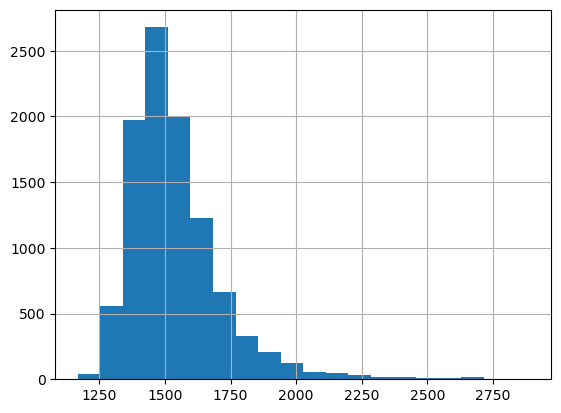

In [54]:
my_plotter.show_histogram(df["Rotational speed [rpm]"], 20)

Let's apply the Box-Cox transformation to remove the skew:

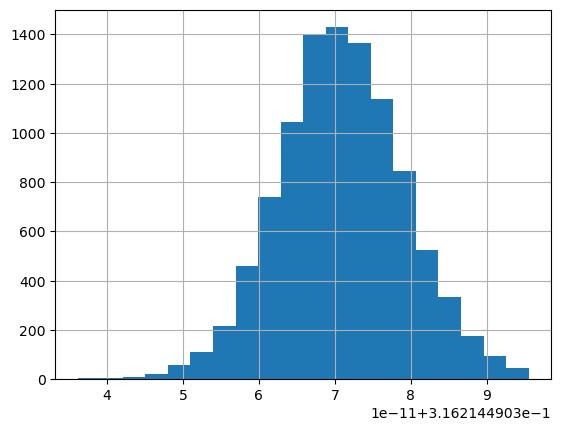

In [55]:
my_dataframe_transformer.apply_box_cox(df["Rotational speed [rpm]"])
df_transformed = df
df_transformed["Rotational speed [rpm]"] = my_dataframe_transformer.apply_box_cox(df["Rotational speed [rpm]"])

my_plotter.show_histogram(df_transformed["Rotational speed [rpm]"], 20)

Now the skew is gone!

## Removing Outliers

- Let's calculate the z-scores for all the columns of type `int64` or `float64`.

In [56]:
for column in ["Type", "Air temperature [K]","Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]" ]:
    df_transformed[f"{column} z_scores"] = (df_transformed[column] - df_transformed[column].mean()) / df_transformed[column].std()

print(f"The total number of entires before removal is {df_transformed['UDI'].count()}")

df_transformed.head()

The total number of entires before removal is 10000


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,...,RNF,Missing Air Temp,Missing Process Temp,Missing Tool Wear,Type z_scores,Air temperature [K] z_scores,Process temperature [K] z_scores,Rotational speed [rpm] z_scores,Torque [Nm] z_scores,Tool wear [min] z_scores
0,3416,L50595,0,301.4,310.4,0.316214,36.9,133.0,False,False,...,False,False,False,False,-0.745269,0.723072,0.269253,0.481080,-0.309653,0.399509
1,7130,L54309,0,300.6,310.0,0.316214,31.0,107.0,False,False,...,False,False,False,False,-0.745269,0.305036,-0.013702,0.787850,-0.901492,-0.019481
2,2320,M17179,1,299.2,308.8,0.316214,33.5,185.0,False,False,...,False,False,False,False,0.744376,-0.426528,-0.862568,1.093228,-0.650713,1.237491
3,9601,M24460,1,298.9,310.0,0.316214,45.3,58.0,False,False,...,False,False,False,False,0.744376,-0.583291,-0.013702,0.372539,0.532965,-0.809118
4,614,L47793,0,298.1,309.9,0.316214,30.0,53.0,False,False,...,False,False,False,False,-0.745269,-1.001327,-0.084441,0.782750,-1.001803,-0.889693


Now we'll remove all rows which have an entry of z-score greater than 3 in maginitude.

In [57]:
for column in ["Type", "Air temperature [K]","Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]" ]:
    df_transformed = df_transformed = df_transformed[abs(df_transformed[f"{column} z_scores"]) < 3]

print(f"The total number of entires after removal is {df_transformed['UDI'].count()}")

df_transformed.head(10)

The total number of entires after removal is 9950


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,...,RNF,Missing Air Temp,Missing Process Temp,Missing Tool Wear,Type z_scores,Air temperature [K] z_scores,Process temperature [K] z_scores,Rotational speed [rpm] z_scores,Torque [Nm] z_scores,Tool wear [min] z_scores
0,3416,L50595,0,301.4,310.4,0.316214,36.9,133.0,False,False,...,False,False,False,False,-0.745269,0.723072,0.269253,0.481080,-0.309653,0.399509
1,7130,L54309,0,300.6,310.0,0.316214,31.0,107.0,False,False,...,False,False,False,False,-0.745269,0.305036,-0.013702,0.787850,-0.901492,-0.019481
2,2320,M17179,1,299.2,308.8,0.316214,33.5,185.0,False,False,...,False,False,False,False,0.744376,-0.426528,-0.862568,1.093228,-0.650713,1.237491
3,9601,M24460,1,298.9,310.0,0.316214,45.3,58.0,False,False,...,False,False,False,False,0.744376,-0.583291,-0.013702,0.372539,0.532965,-0.809118
4,614,L47793,0,298.1,309.9,0.316214,30.0,53.0,False,False,...,False,False,False,False,-0.745269,-1.001327,-0.084441,0.782750,-1.001803,-0.889693
5,4602,M19461,1,303.0,311.1,0.316214,54.3,117.0,True,False,...,False,False,False,False,0.744376,1.559144,0.764425,-1.163748,1.435769,0.141669
6,5247,L52426,0,300.1,310.1,0.316214,41.0,56.0,False,False,...,False,True,True,False,-0.745269,0.043763,0.057037,-0.305023,0.101625,-0.841348
7,7008,L54187,0,300.5,310.6,0.316214,45.2,8.0,False,False,...,False,False,False,False,-0.745269,0.252781,0.410731,-0.044276,0.522934,-1.614869
8,9375,M24234,1,297.8,308.5,0.316214,44.7,88.0,False,False,...,False,False,False,False,0.744376,-1.158091,-1.074785,-0.296994,0.472778,-0.325667
9,1962,L49141,0,297.8,310.1,0.316214,51.2,107.0,False,False,...,False,False,True,False,-0.745269,-1.158091,0.057037,-0.445115,1.124803,-0.019481


Let's drop the z-score and missing value columns as we won't need them anymore:

In [58]:
df_transformed = df_transformed[df_transformed.columns[0:14]]

df_transformed

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,3416,L50595,0,301.4,310.4,0.316214,36.9,133.0,False,False,False,False,False,False
1,7130,L54309,0,300.6,310.0,0.316214,31.0,107.0,False,False,False,False,False,False
2,2320,M17179,1,299.2,308.8,0.316214,33.5,185.0,False,False,False,False,False,False
3,9601,M24460,1,298.9,310.0,0.316214,45.3,58.0,False,False,False,False,False,False
4,614,L47793,0,298.1,309.9,0.316214,30.0,53.0,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9018,M23877,1,297.3,308.1,0.316214,52.0,214.0,False,False,False,False,False,False
9996,3339,M18198,1,301.6,310.9,0.316214,40.9,152.0,False,False,False,False,False,False
9997,5771,L52950,0,301.6,311.2,0.316214,42.9,89.0,False,False,False,False,False,False
9998,3056,L50235,0,300.1,309.2,0.316214,37.6,73.0,False,False,False,False,False,False


## Overly correlated columns

Let's plot the correlation matrix again:

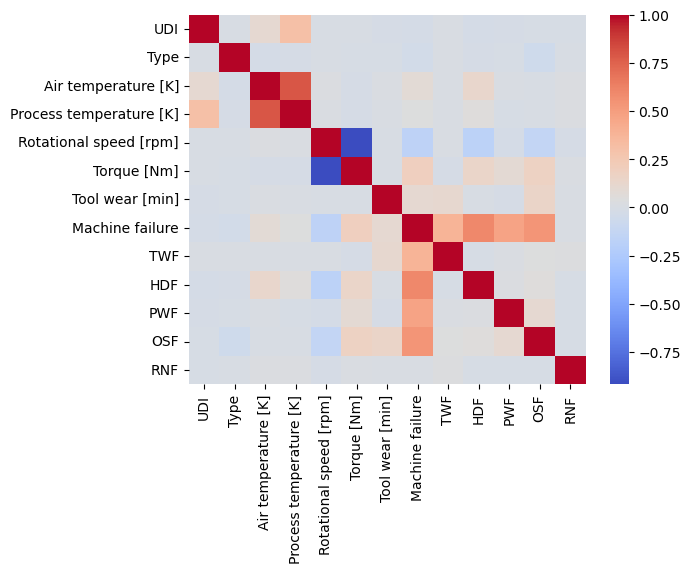

In [59]:
my_plotter.show_correlation_plot(df_transformed)

**Air temperature [K]** and **Process temperature [K]** are highly correlated. Let's plot a scattergraph:

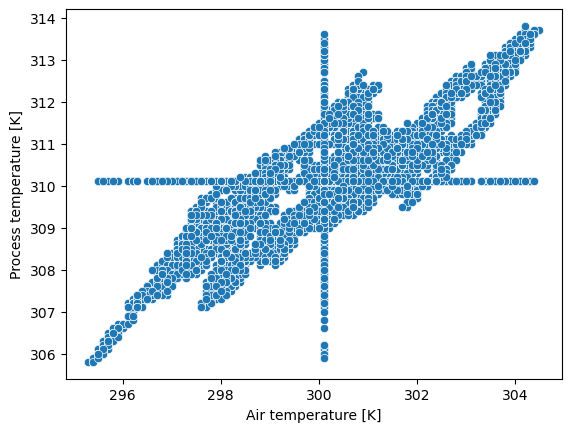

In [60]:
my_plotter.show_scatter_plot(df_transformed['Air temperature [K]'], df_transformed['Process temperature [K]'])

The plot suggest that the correlation is not strong enough to drop either column.

**Rotational speed [rpm]** and **Torque [Nm]** seem to be correlated which makes sense since torque multiplied by rotational speed is the power output, which we'd think is fixed or must be within a certain range, but if we look at a scatter plot:

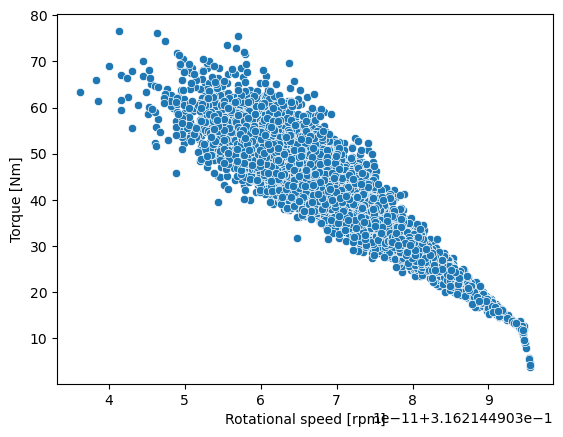

In [61]:
my_plotter.show_scatter_plot(df['Rotational speed [rpm]'], df['Torque [Nm]'])

We deduce that the correlation is not strong enough to drop either. Infact we should probably add a new column of the multiple of the two.

In [62]:
df_transformed["Power Output"] = df_transformed["Rotational speed [rpm]"] * df_transformed["Torque [Nm]"]

df_transformed.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Power Output
0,3416,L50595,0,301.4,310.4,0.316214,36.9,133.0,False,False,False,False,False,False,11.668315
1,7130,L54309,0,300.6,310.0,0.316214,31.0,107.0,False,False,False,False,False,False,9.802649
2,2320,M17179,1,299.2,308.8,0.316214,33.5,185.0,False,False,False,False,False,False,10.593185
3,9601,M24460,1,298.9,310.0,0.316214,45.3,58.0,False,False,False,False,False,False,14.324516
4,614,L47793,0,298.1,309.9,0.316214,30.0,53.0,False,False,False,False,False,False,9.486435


# Analysis and Visualisation

The following shows the range of values of some columns, and the range when restricted to certain types:

In [63]:
my_list = []

for item in ["Air temperature [K]","Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]" ]:
    my_dict = {
        "Name":item,
        "Min Value": df[item].min(),
        "Max Value": df[item].max(),
        "Range": df[item].max() - df[item].min()
    }

    def quality_string(number:int):
        if number == 0: return "Low"
        if number == 1: return "Medium"
        if number == 2: return "High"

    for quality in [0,1,2]:
        my_dict["Min value of type " + quality_string(quality)] = df[df["Type"] == quality][item].min()
        my_dict["Max value of type " + quality_string(quality)] = df[df["Type"] == quality][item].max()

    my_list.append(my_dict)

pd.DataFrame(my_list)

,Name,Min Value,Max Value,Range,Min value of type Low,Max value of type Low,Min value of type Medium,Max value of type Medium,Min value of type High,Max value of type High
0,Air temperature [K],295.300000,304.500000,9.200000e+00,295.300000,304.500000,295.300000,304.400000,295.500000,304.200000
1,Process temperature [K],305.700000,313.800000,8.100000e+00,305.700000,313.800000,305.700000,313.800000,305.900000,313.500000
2,Rotational speed [rpm],0.316214,0.316214,5.941186e-11,0.316214,0.316214,0.316214,0.316214,0.316214,0.316214
3,Torque [Nm],3.800000,76.600000,7.280000e+01,3.800000,76.600000,9.700000,76.200000,12.800000,72.800000
4,Tool wear [min],0.000000,253.000000,2.530000e+02,0.000000,251.000000,0.000000,253.000000,0.000000,246.000000


The next table shows at what states of wear the tools have been operating at.

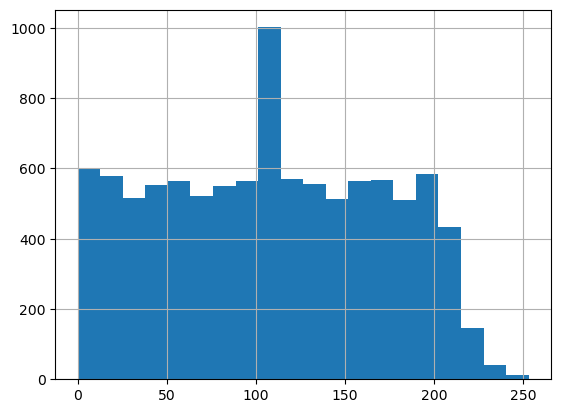

In [64]:
my_plotter.show_histogram(df_transformed["Tool wear [min]"])

## Failure statistics

Let's create a few masks to help analyse the data.

In [65]:
mask_low = df_transformed["Type"] == 0
mask_med = df_transformed["Type"] == 1
mask_high = df_transformed["Type"] == 2

mask_failed = df_transformed["Machine failure"] == 1

Now we define a new table just containing the records of failed processes:

In [66]:
df_of_failiures = df_transformed[mask_failed]

df_of_failiures.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Power Output
5,4602,M19461,1,303.0,311.1,0.316214,54.3,117.0,True,False,True,False,False,False,17.170447
67,4407,L51586,0,302.5,310.3,0.316214,58.5,55.0,True,False,True,False,False,False,18.498548
87,5942,L53121,0,300.6,310.7,0.316214,48.5,78.0,True,False,False,False,False,False,15.336403
92,4732,L51911,0,303.3,311.6,0.316214,45.1,219.0,True,False,True,False,False,False,14.261274
97,6179,L53358,0,301.1,310.9,0.316214,67.9,10.0,True,False,False,True,False,False,21.470964


We can also calculate the total percentage of failed processes.

In [43]:
total_faliures = df_transformed[mask_failed]["Machine failure"].count()

total_count = df_transformed["Machine failure"].count()

print(f"Total number of machine failiuires is is {(total_faliures / total_count) * 100} %")

Total number of machine failiuires is is 3.1155778894472363 %


We can also see the failure amounts by quality type:

In [82]:
my_dict = {
    "Quality": ["Low", "Medium", "High"],
    "Total operations": [df_transformed[mask_low]["Machine failure"].count(), df_transformed[mask_med]["Machine failure"].count(), df_transformed[mask_high]["Machine failure"].count()],
    "Total Failures": [df_transformed[mask_low & mask_failed]["Machine failure"].count(), df_transformed[mask_med & mask_failed]["Machine failure"].count(), df_transformed[mask_high & mask_failed]["Machine failure"].count()],
    }

my_dict["Percentage of failures %" ] =  [(my_dict["Total Failures"][index] / my_dict["Total operations"][index]) * 100 for index in [0,1,2]]

pd.DataFrame(my_dict)

,Quality,Total operations,Total Failures,Percentage of failures %
0,Low,5971,217,3.634232
1,Medium,2978,73,2.451310
2,High,1001,20,1.998002


We can also plot a bar chart showing the causes of failure.

/tmp/ipykernel_33235/3608311331.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "Amount": [df_of_failiures[df[index] == 1]["Machine failure"].count() for index in df_of_failiures.columns[9:14]]


<Axes: xlabel='Failure_type', ylabel='Amount'>

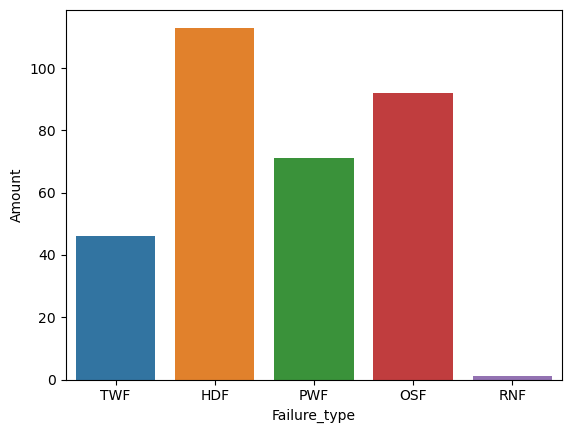

In [83]:
import seaborn as sns

my_dict = {
    "Failure_type": df_of_failiures.columns[9:14].to_list(),
    "Amount": [df_of_failiures[df[index] == 1]["Machine failure"].count() for index in df_of_failiures.columns[9:14]]
}

pd.DataFrame(my_dict)

sns.barplot(pd.DataFrame(my_dict), x = "Failure_type", y = "Amount")



Let's examine the correlations between various causes of failure:

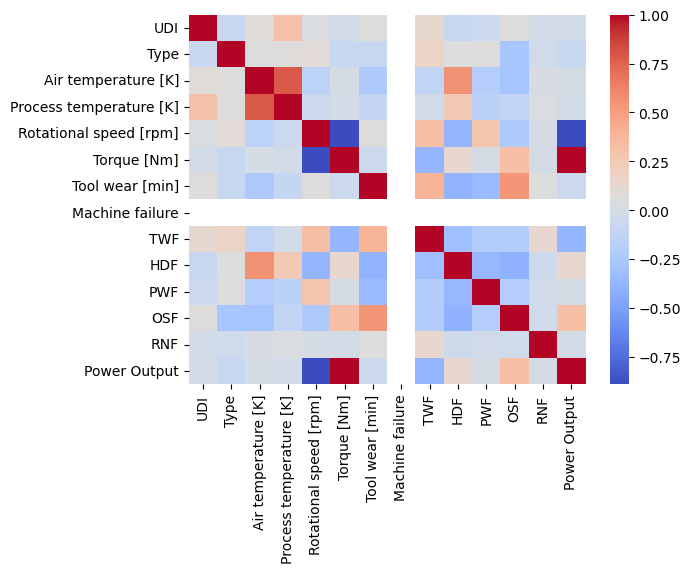

In [84]:
my_plotter.show_correlation_plot(df_of_failiures)

In [85]:
df_of_failiures.corr()

/tmp/ipykernel_33235/4196069615.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_of_failiures.corr()


,UDI,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Power Output
UDI,1.000000,-0.073941,0.077535,0.312794,0.028740,-0.019220,0.062712,NaN,0.128221,-0.086908,-0.066524,0.063412,-0.025891,-0.019220
Type,-0.073941,1.000000,0.057133,0.069526,0.087435,-0.087160,-0.085235,NaN,0.169718,0.053677,0.065438,-0.276721,-0.034529,-0.087160
Air temperature [K],0.077535,0.057133,1.000000,0.779326,-0.157191,0.005587,-0.239366,NaN,-0.126764,0.561215,-0.196708,-0.283901,0.023678,0.005587
Process temperature [K],0.312794,0.069526,0.779326,1.000000,-0.064559,-0.023230,-0.101670,NaN,-0.024379,0.259824,-0.164173,-0.119850,0.027236,-0.023230
Rotational speed [rpm],0.028740,0.087435,-0.157191,-0.064559,1.000000,-0.889782,0.067679,NaN,0.335054,-0.378031,0.284700,-0.239066,0.003073,-0.889782
Torque [Nm],-0.019220,-0.087160,0.005587,-0.023230,-0.889782,1.000000,-0.058726,NaN,-0.373002,0.134088,-0.002023,0.325228,-0.016495,1.000000
Tool wear [min],0.062712,-0.085235,-0.239366,-0.101670,0.067679,-0.058726,1.000000,NaN,0.390489,-0.388520,-0.347460,0.547157,0.049826,-0.058726
Machine failure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TWF,0.128221,0.169718,-0.126764,-0.024379,0.335054,-0.373002,0.390489,NaN,1.000000,-0.316143,-0.205919,-0.211580,0.136284,-0.373002
HDF,-0.086908,0.053677,0.561215,0.259824,-0.378031,0.134088,-0.388520,NaN,-0.316143,1.000000,-0.364947,-0.403980,-0.043085,0.134088


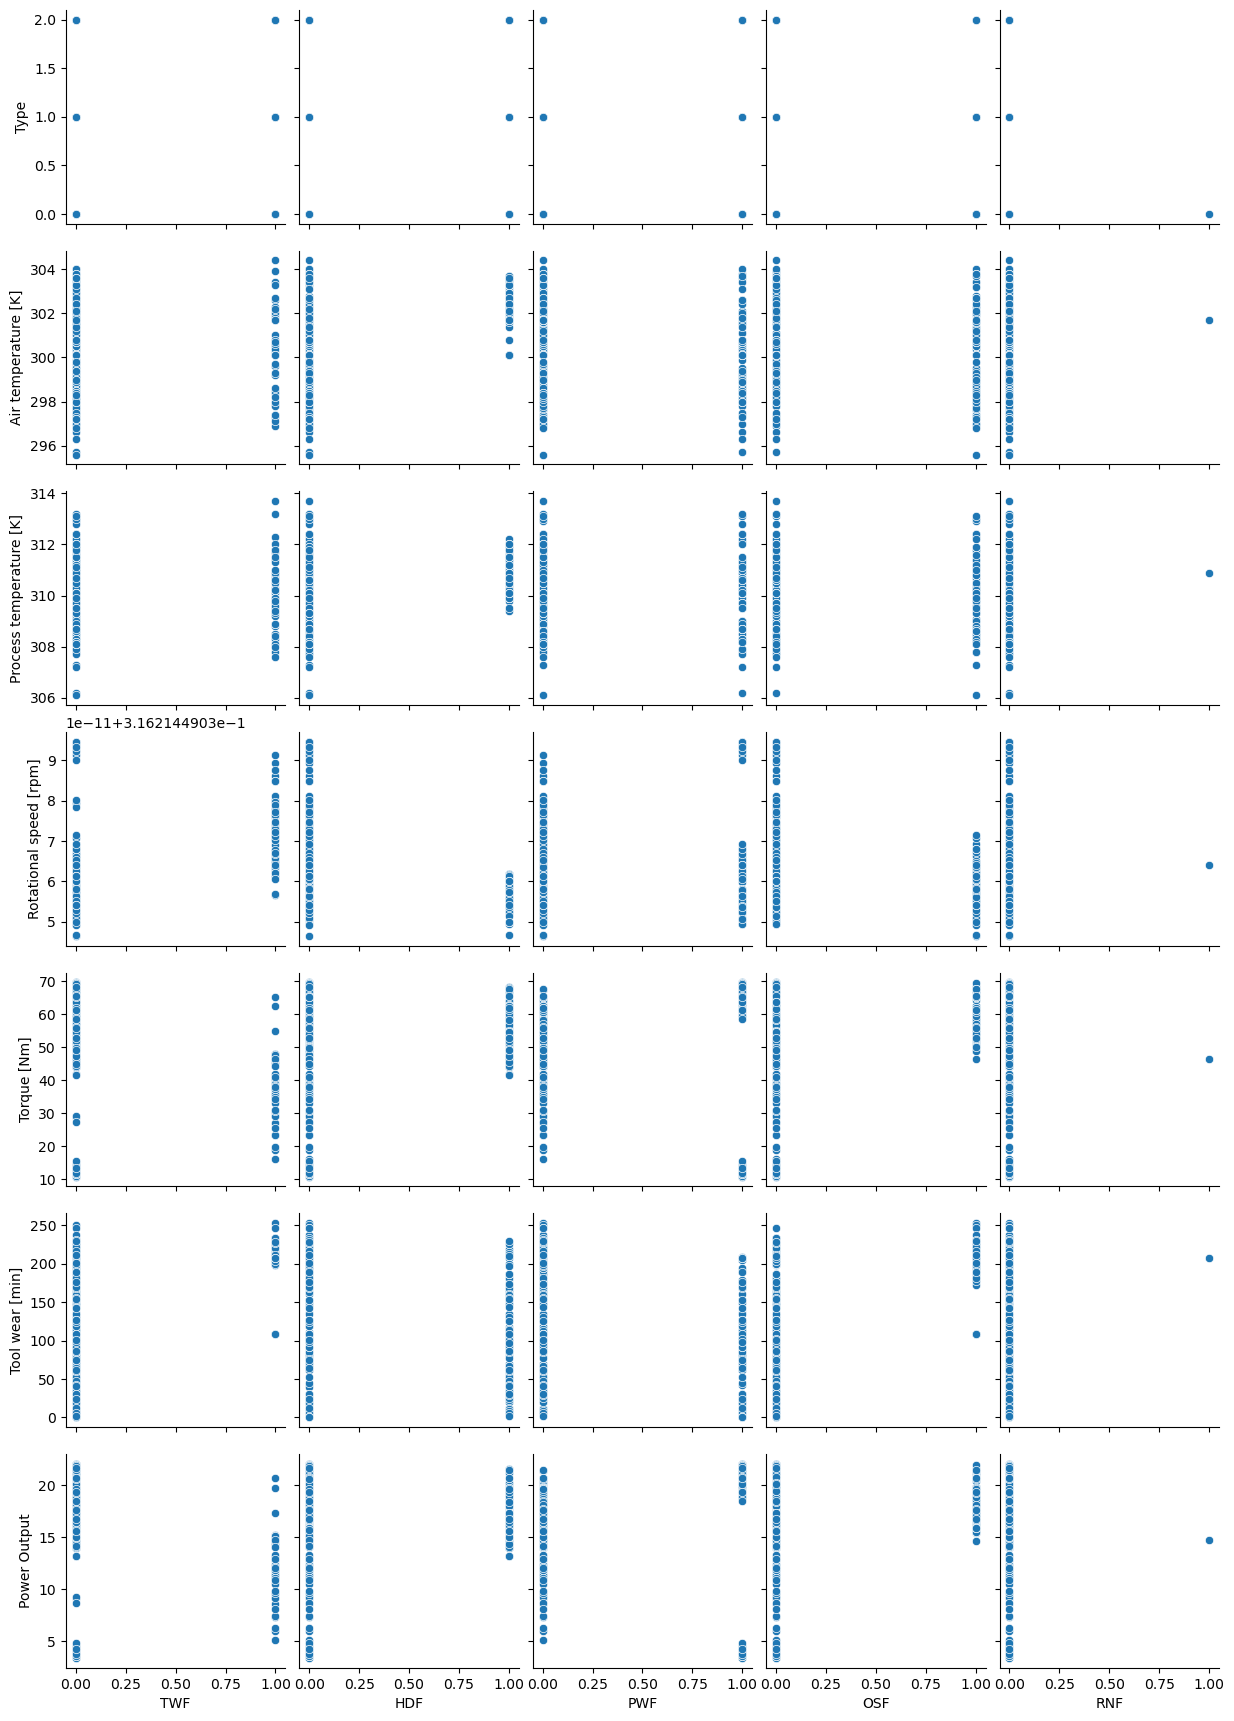

In [87]:
sns.pairplot(
    df_of_failiures,
    y_vars = ["Type", "Air temperature [K]", "Process temperature [K]",	"Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]", "Power Output"],
    x_vars=df_of_failiures.columns[9:14].to_list()
    )

From this we deduce the following about failures:

- Tool wear failure mainly happens after a high amount of tool wear, but also at high rotational speeds.
- Heat dissipation failure mainly happens at high air tempretures, but it also happens at high torque outputs and process temperatures.
- Power failure seems to be evenly distibuted among machine conditions but mainly happens at high power outputs
- Overstrain failure mainly happens at high torque conditions and at high tool wear.
- We can't deduce much on the occurence of random failures.

From this we have the following suggestions:

- Limit rotational speeds on tools with a high amount of tool wear. 
- Limit torque output when the air tempreature is high